In this chapter, we will cover the Data API, the TFRecord format, and how to create custom preprocessing layers and use the standard Keras ones. We will also take a quick look at a few related projects from TensorFlow’ ecosystem

TF Transform (tf.Transform)

* Makes it possible to write a single preprocessing function that can be run in batch mode on your full training set, before training (to speed it up), and then exported to a TF Function and incorporated into your trained model so that once it is deployed in production it can take care of preprocessing new instances on the fly 

TF Datasets (TFDS)

* Provides a convenient function to download many common datasets of all kinds, including large ones like ImageNet, as well as convenient dataset objects to manipulate them using the Data API

# The Data API

The whole Data API revolves around the concept of a dataset: as you might suspect, this represents a sequence of data items

Usually you will use datasets that gradually read data from disk, but for simplicity **let’s create a dataset entirely in RAM using tf.data.Dataset.from_tensor_slices():**

In [1]:
import tensorflow as tf
from tensorflow import keras

X = tf.range(10) # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

The from_tensor_slices() function takes a tensor and creates a tf.data.Dataset whose elements are all the slices of X (along the first dimension), so this dataset contains 10 items: tensors 0, 1, 2, ..., 9. In this case we would have obtained the same dataset if we had used tf.data.Dataset.range(10)

You can simply iterate over a dataset's items like this:

In [2]:
for item in dataset:
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


## Chaining Transformations

Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. Each method returns a new dataset, so you can chain transformations like this (this chain is illustrated in Figure 13-1):

In [3]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
  print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


<p align='center'>
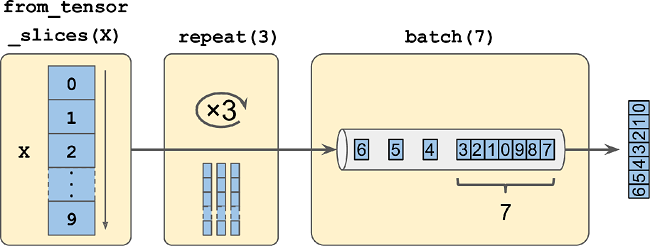
</p>
Figure 13-1. Chaining dataset transformations

In this example, we first call the repeat() method on the original dataset, and it returns a new dataset that will repeat the items of the original dataset three times

Of course, this will not copy all the data in memory three times! (If you call this method with no arguments, the new dataset will repeat the source dataset forever, so the code that iterates over the dataset will have to decide when to stop)

Then we call the batch() method on this new dataset, and again this creates a new dataset. **This one will group the items of the previous dataset in batches of seven items**

Finally, we iterate over the items of this final dataset. As you can see, the batch() method had to output a final batch of size two instead of seven, but you can call it with drop_remainder=True if you want it to drop this final batch so that all batches have the exact same size

The dataset methods do not modify datasets, they create new ones, so make sure to keep a reference to these new datasets

You can also transform the items by calling the map() method. For example, this creates a new dataset with all items doubled:

In [4]:
dataset = dataset.map(lambda x: x * 2)

for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


**This function is the one you will call to apply any preprocessing you want to your data**. Sometimes this will include computations that can be quite intensive, such as reshaping or rotating an image, so you will usually want to spawn multiple threads to speed things up: it’s as simple as setting the num_parallel_calls argument

Note that the function you pass to the method must be convertible to a TF Function map()

While the map() method applies a transformation to each item, the apply() method applies a transformation to the dataset as a whole

For example, the following code applies the unbatch() function to the dataset. Each item in the new dataset will be a single integer tensor instead of a batch of seven integers:

In [5]:
#dataset = dataset.apply(tf.data.experimental.unbatch()) # Now deprecated
dataset = dataset.unbatch()

It is also possible to simply **filter the dataset using the filter() method:**

In [6]:
dataset = dataset.filter(lambda x: x < 10)

**You will often want to look at just a few items from a dataset. You can use the take() method for that:**

In [7]:
for item in dataset.take(3):
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


## Shuffling the Data

Gradient Descent works best when the instances in the training set are independent and identically distributed. A simple way to ensure this is to shuffle the instances, using the shuffle() method

**It will create a new dataset that will start by filling up a buffer with the first items of the source dataset. Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset**

You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective. Just don’t exceed the amount of RAM you have, and even if you have plenty of it, there’s no need to go beyond the dataset’s size

ou can provide a random seed if you want the same random order every time you run your program. For example, the following code creates and displays a dataset containing the integers 0 to 9, repeated 3 times, shuffled using a buffer of size 5 and a random seed of 42, and batched with a batch size of 7:

In [8]:
tf.random.set_seed(42)

dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for item in dataset:
  print(item)

tf.Tensor([1 3 0 4 2 5 6], shape=(7,), dtype=int64)
tf.Tensor([8 7 1 0 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([4 6 9 8 9 7 0], shape=(7,), dtype=int64)
tf.Tensor([3 1 4 5 2 8 7], shape=(7,), dtype=int64)
tf.Tensor([6 9], shape=(2,), dtype=int64)


If you call repeat() on a shuffled dataset, by default it will generate a new order at every iteration. This is generally a good idea, but if you prefer to reuse the same order at each iteration (e.g., for tests or debugging), you can set reshuffle_each_iteration=False

For a large dataset that does not fit in memory, this simple shuffling buffer approach may not be sufficient, since the buffer will be small compared to the dataset

One solution is to shuffle the source data itself. Even if the source data is shuffled, you will usually want to shuffle it some more, or else the same order will be repeated at each epoch, and the model may end up being biased (e.g., due to some spurious patterns present by chance in the source data’s order)

**To shuffle the instances some more, a common approach is to split the source data into multiple files, then read them in a random order during training**

To avoid this you can pick multiple files randomly and read them simultaneously, interleaving their records. Then on top of that you can add a shuffling buffer using the shuffle() method

### Interleaving lines from multiple files

First, let’s suppose that you’ve loaded the California housing dataset, shuffled it, and split it into a training set, a validation set, and a test set



In [9]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

Then you split each set into many CSV files that each look like this (each row contains eight input features plus the target median house value):

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [10]:
import numpy as np
import os

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [11]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [12]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


Let’s also suppose train_filepaths contains the list of training file paths (and you also have valid_filepaths and test_filepaths):

In [13]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

Alternatively, you could use file patterns; for example, train_filepaths = "datasets/housing/my_train_*/csv". Now let's create a dataset containing only these file paths:

In [14]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [15]:
for filepath in filepath_dataset:
  print(filepath)

tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Ten

By default, the list_file() function returns a dataset that shuffles the file paths. In general tis is a good thing, but you can set shuffle=False if you do not want it for some reason

Next, you can call the interleave() method to read from five files at a time and interleave their lines (skipping the first line of each file, which is the header row, using the skip() method):

In [16]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

The interleave() method will create a dataset that will pull five file paths from the filepath_dataset, and for each one it will call the function you gave it (a lambda in this example) to create a new dataset (in this case a TextLineDataset)

To be clear, at this stage there will be seven datasets in all: the filepath dataset, the interleave dataset, and the five TextLineDatasets created internally by the interleave dataset

When we iterate over the interleave dataset, it will cycle through these five TextLineDatasets, reading one line at a time from each until all datasets are out of items. Then it will get the next five file paths from the filepath_dataset and interleave them the same way, and so on until it runs out of file paths

For interleaving to work best, it is preferable to have files of identical length; otherwise the ends of the longest files will not be interleaved

By default, interleave() does not use parallelis; it just reads one line at a time from each file, sequentially. If you want it to actually read files in parallel, you can set the num_parallel_calls argument to the number of threads you want (note that the map() method also has this argument)

You can even set it to tf.data.experimental.AUTOTUNE to make TensorFlow choose the right number of threads dynamically based on the available CPU

Let’s look at what the dataset contains now:

In [17]:
for line in dataset.take(5):
  print(line.numpy())

b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159'
b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'


These are the first rows (ignoring the header row) of five CSV files, chosen randomly. Looks good! But as you can see, these are just byte strings; we need to parse them and scale the data

Notice that field 4 is interpreted as a string

In [18]:
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

Notice that all missing fields are replaced with their default value, when provided:

In [19]:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

The 5th field is compulsory (since we provided tf.constant([]) as the "default value"), so we get an exception if we do not provide it:

In [20]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


The number of fields should match exactly the number of fields in the record_defaults:

In [21]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


## Preprocessing the Data

Let’s implement a small function that will perform this preprocessing:

In [22]:
n_inputs = 8

@tf.function
def preprocess(line):
  defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
  fields = tf.io.decode_csv(line, record_defaults=defs)
  x = tf.stack(fields[:-1])
  y = tf.stack(fields[-1:])
  return (x - X_mean) / X_std, y

* First, the code assumes that we have precomputed the mean and standard deviation of each feature in the training set. X_mean and X_std are just 1D tensors (or NumPy arrays) containing eight floats, one per input feature

* The preprocess() function takes one CSV line and starts by parsing it. For this it uses the tf.io.decode_csv() function, which takes **two arguments: the first is the line to parse, and the second is an array containing the default value for each column in the CSV file**. This array tells TensorFlow not only the default value for each column, but also the number of columns and their types. In this example, we tell it that all feature columns are floats and that missing values should default to 0, but we provide an empty array of type tf.float32 as the default value for the last column (the target): the array tells TensorFlow that this column contains floats, but that there is no default value, so it will raise an exception if it encounters a missing value

* The decode_csv() function returns a list of scalar tensors (one per column), but we need to return 1D tensor arrays. So we call tf.stack() on all tensors except for the last one (the target): this will stack these tensors into a 1D array. We then do the same for the target value (this makes it a 1D tensor array with a single value, rather than a scalar tensor)

* Finally, we scale the input features by subtracting the feature means and then dividing by the feature standard deviations, and we return a tuple containing the scaled features and the target

Let’s test this preprocessing function:

In [23]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

## Putting Everything Together

To make the code reusable, let’s put together everything we have discussed so far into a small helper function: it will create and return a dataset that will efficiently load California housing data from multiple CSV files, preprocess it, shuffle it, optionally repeat it, and batch it (see Figure 13-2):

In [24]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

Everything should make sense in this code, except the very last line prefetch(1), which is important for performance

<p align='center'>
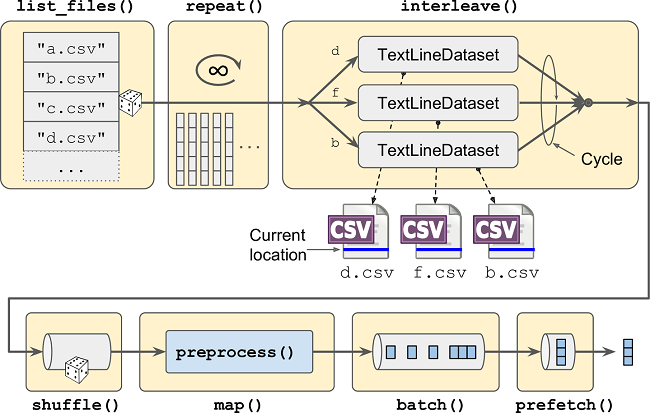
</p>
Figure 13-2. Loading and preprocessing data from multiple CSV files

## Prefetching

**By calling prefetch(1) at the end, we are creating a dataset that will do its best to always be one batch ahead**. In other words, while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (e.g., reading the data from disk and preprocessing it)

This can improve performance dramatically, as is illustrated in Figure 13-3. If we also ensure that loading and preprocessing are multithreaded (by setting num_parallel_calls when calling interleave() and map()), **we can exploit multiple cores on the CPU and hopefully make preparing one batch of data shorter than running a training step on the GPU**: this way the GPU will be almost 100% utilized (except for the data transfer time from the CPU to the GPU ), and training will run much faster

<p align='center'>
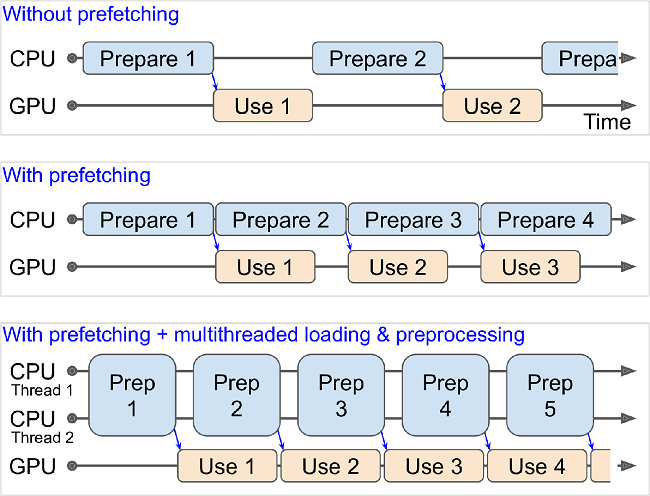
</p>
Figure 13-3. With prefetching, the CPU and the GPU work in parallel: as the GPU works on one batch, the CPU works on the next

**If the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset’s cache() method to cache its content to RAM**. You should generally do this after loading and preprocessing the data, but before shuffling, repeating, batching, and prefetching

This way, each instance will only be read and preprocessed once (instead of once per epoch), but the data will still be shuffled differently at each epoch, and the next batch will still be prepared in advance

You now know how to build efficient input pipelines to load and preprocess data from multiple text files. We have discussed the most common dataset methods, but there are a few more you may want to look at: concatenate(), zip(), window(), reduce(), shard(), flat_map() and padded_batch()

There are also a couple more class methods: from_generator() and from_tensors(), which create a new dataset from a Python generator or a list of tensors, respectively

Also note that there are experimental features available in tf.data.experimental, many of which will likely make it to the core API in future releases (e.g check out the CSvDataset class, as well as the make_csv_dataset() method, which takes care of inferring the type of each column)



## Using the Dataset with tf.keras

Now we can use the csv_reader_dataset() function to create a dataset for the training set. Note that we do not need to repeat it, as this will be taken care of by tf.keras. We also create datasets for the validation set and the test set:

In [25]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



In [26]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

And now we can simply build and train a Keras model using these datasets. All we need to do is pass the training and validation datasets to the fit() method, instead of X_train, y_train, X_valid, and y_valid

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)


Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 1.4679 - val_loss: 21.5124
Epoch 2/10
362/362 [==============================] - 1s 2ms/step - loss: 0.8735 - val_loss: 0.6648
Epoch 3/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6317 - val_loss: 0.6196
Epoch 4/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5933 - val_loss: 0.5669
Epoch 5/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5629 - val_loss: 0.5402
Epoch 6/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5693 - val_loss: 0.5209
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5231 - val_loss: 0.6130
Epoch 8/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5074 - val_loss: 0.4818
Epoch 9/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4963 - val_loss: 0.4904
Epoch 10/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5023 - val_loss: 0.458

Similarly, we can pass a dataset to the evaluate() and predict() methods:

In [28]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 1ms/step - loss: 0.4788


0.4787752032279968

In [29]:
new_set = test_set.take(3).map(lambda X, y: X) # pretend we have 3 new instances
model.predict(new_set) # a dataset containing new instances

array([[1.3206623 ],
       [2.8198109 ],
       [3.249744  ],
       [2.0288205 ],
       [1.6127919 ],
       [1.0435953 ],
       [3.398272  ],
       [2.5609093 ],
       [3.5580819 ],
       [1.2878542 ],
       [1.9824048 ],
       [1.3180974 ],
       [2.2630477 ],
       [1.1518853 ],
       [3.1928034 ],
       [1.7722561 ],
       [2.7276149 ],
       [2.2703788 ],
       [2.5340595 ],
       [0.635628  ],
       [0.96471643],
       [2.3612819 ],
       [1.4603943 ],
       [1.5795335 ],
       [1.98223   ],
       [2.8105965 ],
       [0.77453333],
       [2.7432334 ],
       [1.0429494 ],
       [2.814415  ],
       [2.1154428 ],
       [2.1015055 ],
       [1.5765224 ],
       [1.6122233 ],
       [1.7193551 ],
       [1.832511  ],
       [3.1353652 ],
       [7.3480577 ],
       [1.8008893 ],
       [2.0271199 ],
       [1.7252631 ],
       [2.9369876 ],
       [1.3494132 ],
       [2.8155584 ],
       [2.1258044 ],
       [1.7575475 ],
       [1.352296  ],
       [1.564

Unlike the other sets, the new_set will usually not contain labels (if it does, keras will ignore them)

Note that in all these cases, you can still use NumPy arrays instead of datasets if you want (but of course they need to have been loaded and preprocessed first)

If you want to build your own custom training loop (as in Chapter 12), you can just iterate over the training set, very naturally:

In [30]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In fact, it is even possible to create a TF Function (see Chapter 12) that performs the whole training loop:

In [31]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Congratulations, you now know how to build powerful input pipelines using the Data API! However, so far we have used CSV files, which are common, simple, and convenient but not really efficient, and do not **support large or complex data structures (such as images or audio) very well. So let’s see how to use TFRecords instead**

Here is a short description of each method in the Dataset class:

In [33]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`. (deprecated arguments)
● from_tensor_sli

# The TFRecord Format

The TFRecord format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently

It is a very simple binary format that just contains a sequence of binary records of varying sizes (**each record is comprised of a length, a CRC checksum to check that the length was not corrupted, then the actual data, and finally a CRC checksum for the data**)

You can easily create a TFRecord file using the tf.io.TFRecordWriter class:

In [34]:
with tf.io.TFRecordWriter('my_data.tfrecord') as f:
  f.write(b'This is the first record')
  f.write(b'And this is the second record')

And you can then use a tf.data.TFRecordDataset to read one or more TFRecord files:

In [35]:
filepaths = ['my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
  print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


By default, a TFRecordDataset will read files one by one, but you can make it read multiple files in parallel and interleave their records by setting num_parallel_reads

Alternatively, you could obtain the same result by using list_files() and interleave() as we did earlier to read multiple CSV files

## Compressed TFRecord Files

It can sometimes be useful to **compress** your TFRecord files, especially if they need to be loaded via a network connection. You can create a compressed TFRecord file by setting the options argument:

In [36]:
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter('my_compressed.tfrecord', options) as f:
  f.write(b"This is the first record")
  f.write(b"And this is the second record")

When reading a compressed TFRecord file, you need to specify the compression type:

In [37]:
dataset = tf.data.TFRecordDataset(['my_compressed.tfrecord'],
                                  compression_type='GZIP')
for item in dataset:
  print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


## A Brief Introduction to Protocol Buffers

Even though each record can use any binary format you want, **TFRecord files usually contain serialized protocol buffers (also called protobufs)**

This is a portable, extensible, and efficient binary format developed at Google back in 2001 and made open source in 2008; protobufs are now widely used, in particular in [gRPC](https://grpc.io/), Google’s remote procedure call system. They are defined using a simple language that looks like this:

In [38]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


This definition says we are using version 3 of the protobuf format, and it specifies that each Person object may (optionally) have a name of type string, and id of type int32, and zero or more email fields, each of type string

The numbers 1, 2, and 3 are the field identifiers: they will be used in each record's binary representation. Once you have a definition in a .proto file, you can compile it

This requires protoc, the protobuf compiler, to generate access in Python. Note that the protobuf definitions we will use have already been compiled for you, and their Python classes are part of TensorFlow, so you will not need to use protoc

let’s look at a simple example that uses the access classes generated for the Person protobuf

And let's compile it (the --descriptor_set_out and --include_imports options are only required for the tf.io.decode_proto() example below):

In [39]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [40]:
!ls person*

person.desc  person_pb2.py  person.proto


In [41]:
from person_pb2 import Person
person = Person(name='AL', id=123, email=['a@b.com']) # create a Person

In [42]:
print(person) # display the Person

name: "AL"
id: 123
email: "a@b.com"



In [43]:
person.name # read a field

'AL'

In [44]:
person.name = 'Alice' # modify a field

In [45]:
person.email[0] # repeated fields can be accessed like arrays

'a@b.com'

In [46]:
person.email.append('c@d.com') # add an email address

In [47]:
s = person.SerializeToString() # serialize to a byte string
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [48]:
person2 = Person() # create a new Person
person2.ParseFromString(s) # parse the byte string (27 bytes long)

27

In [49]:
person == person2 # now they are equal

True

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the tf.io.decode_proto() function:

In [50]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

In short, we import the Person class genetared by protoc, we create an instance and play with it, visualizing it and reading and writing some fields, then we serialize it using the SerializeToString() method. This is the binary data that is ready to be saved or transmitted over the network

When reading or receiving this binary data, we can parse it using the ParseFromString() method, and we get a copy of the object that was serialized

We could save the serialized Person object to a TFRecord file, then we could load and parse it. However, SerializeToString() and ParseFromString() are not TensorFlow opeations, so they cannot be included in a TensorFlow Function (except by wrapping them in a tf.py_function() operation, which would make the code slower and less portablem as we saw in Chapter12)

Fortunately, TensorFlow does include special protobuf definitions for which it provides parsing operations


## TensorFlow Protobufs

The main protobuf typically used in a TFRecord file is the Example protobuf, which represents one instance in a dataset. It contains a list of named features, where each feature can either be a list of byte strings, a list of floats, or a list of integers. Here is the protobuf definition:



```
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```



The definitions of ByteList, FloatList and Int64List are straightforward enough. Note that [packed = true] is used for repeated numerical fields, for a more efficient encoding

A Feature contains either a BytesList, a FloatList or an Int64List. A Features (with an s) contains a dictionary that maps a feature name to the corresponding feature value. And finally, an Example contains only a Features object

Here is how you could create a tf.train.Example representing the same person as earlier and write it to a TFRecord file:

In [51]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

The code is a bit verbose and repetitive, but it’s rather straightforward (and you could easily wrap it inside a small helper function)

Now that we have an Example protobuf, we can serialize it by calling its SerializeToString() method, then write the resulting data to a TFRecord file:

In [52]:
with tf.io.TFRecordWriter('my_contacts.tfrecord') as f:
  f.write(person_example.SerializePartialToString())

Normally you would write much more than one Example! Typically, you would create a conversion script that reads from your current format (say, CSV files), creates an Example protobuf for each instance, serializes them, and saves them to several TFRecord files, ideally shuffling them in the process

## Loading and Parsing Examples

To load the serialized Example protobufs, we will use a tf.data.TFRecordDataset once again, and we will parse each Example using tf.io.parse_single_example()

This is a TensorFlow operation, so it can be included in a TF Function. **It requires at least two arguments: a string scalar tensor containing the serialized data, and a description of each feature**

The description is a dictionary that maps each feature name to either a tf.io.FixedLenFeature descriptor indicating the feature's shape, type, and default value, or a tf.io.VarLenFeature descriptor indicating only the type (if the length of the feature’s list may vary, such as for the 'emails' feature)

The following code defines a description dictionary, then it iterates over the TFRecordDataset and parses the serialized Example protobuf this dataset contains:



In [53]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [54]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f18b89b5d50>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [55]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [56]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [57]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

The fixed-length features are parsed as regular tensors, but the variable length features are parsed as sparse tensors. You can convert a sparse tensor to a dense tensor using tf.sparse.to_dense(), but in this case it is simpler to just access its values:

In [58]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [59]:
parsed_example['emails'].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

A BytesList can contain any binary data you want, including any serialized object. For example, you can use tf.io.encode_jpeg() to encode an image using the JPEG format and put this binary data in a BytesList

Later, when your code reads the TFRecord, it will start by parsing the Example, then it will need to call tf.io.decode_jpeg() to parse the data and get the original image (or you can use tf.io.decode_image(), which can decode any BMP, GIF, JPEG, or PNG image)

You can also store any tensor you want in a BytesList by serializing the tensor using tf.io.serialize_tensor() then putting the resulting byte string in a BytesList feature. Later, when you parse the TFRecord, you can parse this data using tf.io.parse_tensor()

Instead of parsing examples one by one using tf.io.parse_single_example(), you may want to parse them batch by batch using tf.io.parse_example()


In [60]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
  parsed_examples = tf.io.parse_example(serialized_examples,
                                        feature_description)

As you can see, the Example protobuf will probably be sufficient for most use cases. However, it may be a bit cumbersome to use when you are dealing with lists of lists

For example, suppose you want to classify text documents. Each document may be represented as a list of sentences, where each sentence is represented as a list of words. And perhaps each document also has a list of comments, where each comment is represented as a list of words. There may be some contextual data too, such as the document’s author, title, and publication date. TensorFlow’s SequenceExample protobuf is designed for such use cases

## Handling Lists of Lists Using the SequenceExample Protobuf

Here is the definition of the SequenceExample protobuf:



```
message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
Features context = 1;
FeatureLists feature_lists = 2;
};
```



A SequenceExample contains a Features object for the contextual data and a FeatureLists object that contains one or more named FeatureList objects (e.g., a FeatureList named 'content' and another named 'comments'.)

Each FeatureList contains a list of Feature objects, each of which may be a list of byte strings, a list of 64-bit integers, or a list of floats (in this example, each Feature would represent a sentence or a comment, perhaps in the form of a list of word identifiers

Building a SequenceExample, serializing it, and parsing it is similar to building, serializing, and parsing an Example, but you must use tf.io.parse_single_sequence_example() to parse a single SequenceExample or tf.io.parse_sequence_example() to parse a batch

Both functions return a tuple containing the context features (as a dictionary) and the feature lists (also as a dictionary). If the feature lists contain sequences of varying sizes (as in the preceding example), you may want to convert them to ragged tensors, using tf.RaggedTensor.from_sparse()

In [61]:
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [62]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [63]:
serialized_sequence_example = sequence_example.SerializeToString()

In [64]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [65]:
parsed_context

{'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>,
 'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f18b89be590>}

In [66]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [67]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f18b89bee90>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f18b89be390>}

In [68]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# Preprocessing the Input Features

Preparing your data for a neural network requires converting all features into numerical features, generally normalizing them, and more

In particular, if your data contains categorical features or text features, they need to be converted to numbers. This can be done ahead of time when preparing your data files, using any tool you like (e.g., NumPy, pandas, or Scikit-Learn)

Alternatively, you can preprocess your data on the fly when loading it with the Data API (e.g., using the dataset’s map() method), **or you can include a preprocessing layer directly in your model**

For example, here is how you can implement a standardization layer using a lambda layer. For each feature, it subtracts the mean and divides by its standard deviation (plus a tiny smoothing term to avoid division by zero):

In [69]:
means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps = keras.backend.epsilon()
model = keras.models.Sequential([
    keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps)),
    # [...] other layers
])

However, you may prefer to use a nice self-contained custom layer (much like Scikit-Learn’s StandardScaler), rather than having global variables like means and stds dangling around:

In [70]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

Before you can use this standardization layer, you will need to adapt it to your dataset by calling the adapt() method and passing it a data sample

This will allow it to use the appropriate mean and standard deviation for each feature:

In [71]:
std_layer = Standardization()
#std_layer.adapt(data_sample)

This sample must be large enough to be representative of your dataset, but it does not have to be the full training set: in general, a few hundred randomly selected instances will suffice (however, this depends on your task). Next, you can use this preprocessing layer like a normal layer:

In [72]:
model = keras.Sequential()
model.add(std_layer)
# create the rest of the model
# model.compile([...])
# model.fit([...])

If you are thinking that Keras should contain a standardization layer like this one, here’s some good news for you: by the time you read this, the keras.layers.Normalization layer will probably be available

will work very much like our custom Standardization layer: first, create the layer, then adapt it to your dataset by passing a data sample to the adapt() method, and finally use the layer normally

## Encoding Categorical Features Using One-Hot Vectors

Consider the ocean_proximity feature in the California housing dataset we explored in Chapter 2: it is a categorical feature with five possible values: "<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", and "ISLAND"

We need to encode this feature before we feed it to a neural network. Since there are very few categories, we can use one-hot encoding

For this, we first need to map each category to its index (0 to 4), which can be done using a lookup table:

In [73]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

* We first define the vocabulary: this is the list of all possible categories

* Then we create a tensor with the corresponding indices (0 to 4)

* Next, we create an initializer for the lookup table, passing it the list of categories and their corresponding indices. In this example, we already have this data, so we use a KeyValueTensorInitializer; but if the categories were listed in a text file (with one category per line), we would use a TextFileInitializer instead

* In the last two lines we create the lookup table, giving it the initializer and specifying the number **of out-of-vocabulary (oov) buckets. If we look up a category that does not exist in the vocabulary, the lookup table will compute a hash of this category and use it to assign the unknown category to one of the oov buckets**. Their indices start after the known categories, so in this example the indices of the two oov buckets are 5 and 6

Why use oov buckets? Well, if the number of categories is large (e.g., zip codes, cities, words, products, or users) and the dataset is large as well, or it keeps changing, then getting the full list of categories may not be convenient

One solution is to define the vocabulary based on a data sample (rather than the whole training set) and add some oov buckets for the other categories that were not in the data sample

The more unknown categories you expect to find during training, the more oov buckets you should use. Indeed, if there are not enough oov buckets, there will be collisions: different categories will end up in the same bucket, so the neural network will not be able to distinguish them (at least not based on this feature)

Now let’s use the lookup table to encode a small batch of categorical features to one-hot vectors:

In [74]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [75]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

As you can see, "NEAR BAY" was mapped to index 3, the unknown category "DESERT" was mapped to one of the two oov buckets (at index 5), and "INLAND" was mapped to index 1, twice

Then we used tf.one_hot() to one-hot encode these indices. Notice that we have to tell this function the total number of indices, which is equal to the vocabulary size plus the number of oov buckets

Just like earlier, it wouldn’t be too difficult to bundle all of this logic into a nice self-contained class. Its adapt() method would take a data sample and extract all the distinct categories it contains. It would create a lookup table to map each category to its index (including unknown categories using oov buckets)

Then its call() method would use the lookup table to map the input categories to their indices. Well, here’s more good news: 

by the time you read this, Keras will probably include a layer called keras.layers.TextVectorization, which will be capable of doing exactly that: its adapt() method will convert each category to its index in the vocabulary. You could add this layer at the beginning of your model, followed by a Lambda layer that would apply the tf.one_hot() function, if you want to convert these indices to one-hot vectors

This may not be the best solution, though. The size of each one-hot vector is the vocabulary length plus the number of oov buckets. This is fine when there are just a few possible categories, but **if the vocabulary is large, it is much more efficient to encode them using embeddings instead**

As a rule of thumb, **if the number of categories is lower than 10, then one-hot encoding is generally the way to go (but your mileage may vary!). If the number of categories is greater than 50 (which is often the case when you use hash buckets), then embeddings are usually preferable**. In between 10 and 50 categories, you may want to experiment with both options and see which one works best for your use case

## Encoding Categorical Features Using Embeddings

**An embedding is a trainable dense vector that represents a category**. By default, embeddings are initialized randomly, so for example the "NEAR BAY" category could be represented initially by a random vector such as [0.131, 0.890], while the "NEAR OCEAN" category might be represented by another random vector such as [0.631, 0.791]

In this example, we use 2D embeddings, but the **number of dimensions is a hyperparameter** you can tweak. Since these embeddings are trainable, they will gradually improve during training; and as they represent fairly similar categories, Gradient Descent will certainly end up pushing them closer together, while it will tend to move them away from the "INLAND" category's embedding (see Figure 13-4)

Indeed, the better the representation, the easier it will be for the neural network to make accurate predictions, so training tends to make embeddings useful representations of the categories. This is called representation learning

<p align='center'>
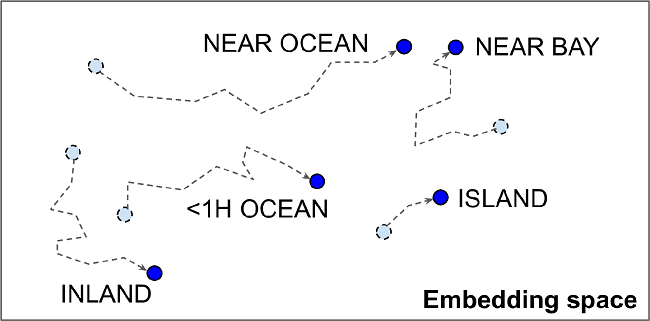
</p>
Figure 13-4. Embeddings will gradually improve during training

Let’s look at how we could implement embeddings manually, to understand how they work (then we will use a simple Keras layer instead)

First, we need to create an embedding matrix containing each category’ embedding, initialized randomly; it will have one row per category and per oov bucket, and one column per embedding dimension:

In [76]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets,
                                embedding_dim])
embedding_matrix = tf.Variable(embed_init)

In this example we are using 2D embeddings, but as a rule of thumb embeddings typically have 10 to 300 dimensions, depending on the task and the vocabulary size

This embedding matrix is a random 6 x 2 matrix, stored in a variable (so it can be tweaked by Gradient Descent during training):

In [77]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.6645621 , 0.44100678],
       [0.3528825 , 0.46448255],
       [0.03366041, 0.68467236],
       [0.74011743, 0.8724445 ],
       [0.22632635, 0.22319686],
       [0.3103881 , 0.7223358 ],
       [0.13318717, 0.5480639 ]], dtype=float32)>

Now let’s encode the same batch of categorical features as earlier, but this time using these embeddings:

In [78]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [79]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.74011743, 0.8724445 ],
       [0.3103881 , 0.7223358 ],
       [0.3528825 , 0.46448255],
       [0.3528825 , 0.46448255]], dtype=float32)>

The tf.nn.embedding_lookup() function looks up the rows in the embedding matrix, at the given indices-that's all it does

For example, the lookup table says that the "INLAND" category is at index 1, so the tf.nn.embedding_lookup() function returns the embedding at row 1 in the embedding matrix (twice): [0.3528825 , 0.46448255]

**Keras provides a keras.layers.Embedding layer that handles the embedding matrix (trainable, by default); when the layer is created it initializes the embedding matrix randomly, and then when it is called with some category indices it returns the rows at those indices in the embedding matrix:**

In [80]:
embedding = keras.layers.Embedding(input_dim=len(vocab) + num_oov_buckets, 
                                   output_dim=embedding_dim)
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.04467482,  0.02493341],
       [-0.02383961,  0.01973433],
       [ 0.04309944, -0.0247813 ],
       [ 0.04309944, -0.0247813 ]], dtype=float32)>

Putting everything together, we can now create a Keras model that can process categorical features (along with regular numerical features) and learn an embedding for each category (as well as for each oov bucket):

In [81]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories], outputs=[outputs])

This model takes two inputs: a regular input containing eight numerical features per instance, plus a categorical input (containing one categorical feature per instance)

It uses a Lambda layer to look up each category's index, then it looks up the embeddings for these indices. Next, it concatenates the embeddings and the regular inputs in order to give the encoded inputs, which are ready to be fed to a neural network. We could add any kind of neural network at this point, but we just add a dense output layer, and we create the Keras model

When the keras.layers.TextVectorization layer is available, you can call its adapt() method to make it extract the vocabulary from a data sample (it will take care of creating the lookup table for you). Then you can add it to your model, and it will perform the index lookup (replacing the Lambda layer in the previous code example)

One-hot encoding followed by a Dense layer (with no activation function and no biases) is equivalent to an Embedding layer. However, the Embedding layer uses way fewer comptations (the performance difference becomes clear when the size of the embedding matrix grows)

The Dense layer’s weight matrix plays the role of the embedding matrix. For example, using one-hot vectors of size 20 and a Dense layer with 10 units is equivalent to using an Embedding layer with input_dim=20. As a result, it would be wasteful to use more embedding dimensions than the number of units in the layer that follows the Embedding layer

### Word Embeddings

Not only will embeddings generally be useful representations for the task at hand, but quite often these **same embeddings can be reused successfully for other tasks. The most common example of this is word embeddings (i.e., embeddings of individual words)**: when you are working on a natural language processing task, you are often better off reusing pretrained word embeddings than training your own

In 2013, when Mikolov and other Google researchers published a [paper](https://arxiv.org/abs/1310.4546) describing an efficient technique to learn word embeddings using neural networks, significantly outperforming previous attempts

This allowed them to learn embeddings on a very large corpus of text: they trained a neural network to predict the words near any given word, and obtained astounding word embeddings. **For example, synonyms had very close embeddings, and semantically related words such as France, Spain, and Italy ended up clustered together**

It’s not just about proximity, though: word embeddings were also organized along meaningful axes in the embedding space. Here is a famous example: if you compute King – Man + Woman (adding and subtracting the embedding vectors of these words), then the result will be very close to the embedding of the word Queen (see Figure 13-5)

In other words, the word embeddings encode the concept of gender! Similarly, you can compute Madrid – Spain + France, and the result is close to Paris, which seems to show that the notion of capital city was also encoded in the embeddings

<p align='center'>
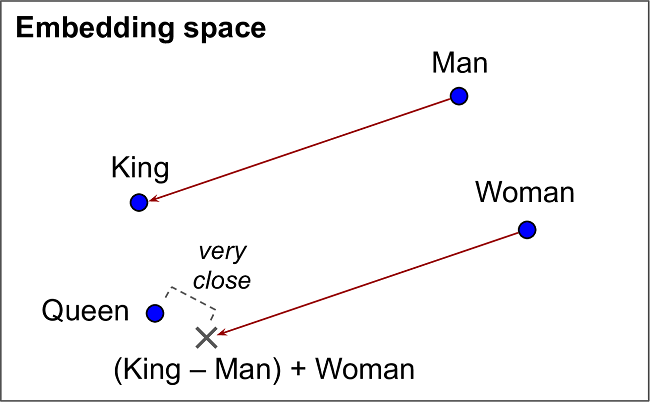
</p>
Figure 13-5. Word embeddings of similar words tend to be close, and some axes seem to encode meaningful concepts

Unfortunately, word embeddings sometimes capture our worst biases. For example, although they correctly learn that Man is to King as Woman is to Queen, they also seem to learn that Man is to Doctor as Woman is to Nurse: quite a sexist bias! To be fair, this particular example is probably exaggerated, as was pointed out in a [2019 paper](https://arxiv.org/abs/1905.09866) by Malvina Nissim et al. Nevertheless, ensuring fairness in Deep Learning algorithms is an important and active research topic

## Keras Preprocessing Layers

The API will also include a keras.layers.Discretization layer that will chop continuous data into different bins and encode each bin as one-hot vector

For example, you could use it to discretize prices into three categories, (low, medium, high), which would be encoded as [1, 0, 0], [0, 1, 0], and [0, 0, 1], respectively

Of course this loses a lot of information, but in some cases it can help the model detect patterns that would otherwise not be obvious when just looking at the continuous values

It will also be possible to chain multiple preprocessing layers using the Preprocessing Stage class. For example, the following code will create a preprocessing pipeline that will first normalize the inputs, then discretize them (this may remind you of Scikit-Learn pipelines)

After you adapt this pipeline to a data sample, you can use it like a regular layer in your models (but again, **only at the start of the model, since it contains a nondifferentiable preprocessing layer)**:

In [82]:
normalization = keras.layers.Normalization()
discretization = keras.layers.Discretization()
#pipeline = keras.layers.PreprocessingStage([normalization, discretization]) 
#No Arrtibute PreprocessingStage
#pipeline.adapt(data_sample)

The TextVectorization layer will also have an option to output word-count vectors instead of word indices

**For example, if the vocabulary contains three words, say ["and", "basketball", "more"], then the text "more and more" will be mapped to the vector [1, 0, 2]: the word "and" appears once, the word "basketball" does not appear at all, and the word "more" appears twice. This text representation is called a bag of words**, since it completely loses the order of the words

Common words like "and" will have a large value in most texts, ven though they are usually the least interesting (e.g., in the text "more and more basketball" the word "basketball" is clearly the most important, precisely because it is not a very frequent word). So, **the word counts should be normalized in a way that reduces the importance of frequent words**

A common way to do this is to **divide each word count by the log of the total number of training instances in which the word appears. This technique is called Term-Frequency Inverse-Document-Frequency (TF IDF)**

For example, let's imagine that the words "and", "basketball", and "more" appear respectively in 200, 10, and 100 text instances in the training set: in this case, the final vector will be [1/log(200), 0/log(10), 2/log(100)], which is approximately equal to [0.19, 0., 0.43]. The Textvectorization layer will have an option to perform TF-IDF

# TF Transform

If preprocessing is computationally expensive, then handling it before training rather than on the fly may give you a significant speedup: the data will be preprocessed just once per instance before training, rather than once per instance and per epoch during training

As mentioned earlier, if the dataset is small enough to fit in RAM, you can use its cache() method. **But if it is too large, then tools like Apache Beam or Spark will help. They let you run efficient data processing pipelines over large amounts of data, even distributed across multiple servers, so you can use them to preprocess all the training data before training**

This works great and indeed can speed up training, but there is one problem: once your model is trained, suppose you want to deploy it to a mobile app. In that case you will need to write some code in your app to take care of preprocessing the data before it is fed to the model. And suppose you also want to deploy the model to TensorFlow.js so that it runs in a web browser?

Once again, you will need to write some preprocessing code. This can become a maintenance nightmare: whenever you want to change the preprocessing logic, you will need to update your Apache Beam code, your mobile app code, and your JavaScript code. This is not only time-consuming, but also error-prone: you may end up with subtle differences between the preprocessing operations performed before training and the ones performed in your app or in the browser. This **training/serving skew** will lead to bugs or degraded performance

**One improvement would be to take the trained model (trained on data that was preprocessed by your Apache Beam or Spark code) and, before deploying it to your app or the browser, add extra preprocessing layers to take care of preprocessing on the fly**. That’s definitely better, since now you just have two versions of your preprocessing code: the Apache Beam or Spark code, and the preprocessing layers’ code

**But what if you could define your preprocessing operations just once? This is what TF Transform was designed for**. It is part of [TensorFlow Extended (TFX)](https://www.tensorflow.org/tfx), an end-to-end platform for productionizing TensorFlow models

First, to use a TFX component such as TF Transform, you must install it; it does not come bundled with TensorFlow. You then define your preprocessing function just once (in Python), by using TF Transform functions for scaling, bucketizing, and more

You can also use any TensorFlow operation you need. Here is what this preprocessing function might look like if we just had two features:

In [83]:
!pip install tensorflow_transform

In [86]:
import tensorflow_transform as tft

def preprocess(inputs): # inputs = a batch of input features
  median_age = inputs['housing_median_age']
  ocean_proximity = inputs['ocean_proximity']
  standardized_age = tft.scale_to_z_score(median_age)
  ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
  return {
      'standardixed_median_age': standardized_age,
      'ocean_proximity_id': ocean_proximity_id
  }

Next, TF Transform lets you apply this preprocess() function to the whole training set using Apache Beam (it provides an AnalyzeAndTransformDataset class that you can use for this purpose in your Apache Beam pipeline)

In the process, it will also compute all the necessary statistics over the whole training set: in this example, the mean and standard deviation of the housing_median_age feature, and the vocabulary for the ocean_proximity feature. The components that compute these statistics are called analyzers

Importantly, TF Transform will also generate an equivalent TensorFlow Function that you can plug into the model you deploy. This TF Function includes some constants that correspond to all the all the necessary statistics computed by Apache Beam (the mean, standard deviation, and vocabulary)

With the Data API, TFRecords, the Keras preprocessing layers, and TF Transform, you can build highly scalable input pipelines for training and benefit from fast and portable data preprocessing in production

# The TensorFlow Datasets (TFDS) Project

The [TensorFlow Datasets](https://www.tensorflow.org/datasets) project makes it very easy to download common datasets, from small ones like MNIST or Fashion MNIST to huge datasets like ImageNet. The list includes image datasets, text datasets (including translation datasets), and audio and video datasets

You can visit [Tensor Flow Datasets](https://www.tensorflow.org/datasets/) to view the full list, along with a description of each dataset

TFDS is not bundled with TensorFlow, so you need to install the tensorflow-datasets library. Then call the tfds.load() function, and it will download the data you want and return the data as a dictionary of datasets

For example, let's download MNIST:


In [88]:
import tensorflow_datasets as tfds

dataset = tfds.load(name='mnist')
mnist_train, mnist_test = dataset['train'], dataset['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


You can then apply any transformation you want (typically shuffling, batching, and prefetching), and you’re ready to train your model. Here is a simple example:

In [89]:
mnist_train = mnist_train.shuffle(10000).batch(32).prefetch(1)
for item in mnist_train:
  images = item['image']
  labels = item['label']

Note that each item in the dataset is a dictionary containing both the features and the labels. But **Keras expects each item to be a tuple containing two elements (again, the features and the labels)**. You could transform the dataset using the map() method, like this:

In [90]:
mnist_train = mnist_train.shuffle(10000).batch(32)
mnist_train = mnist_train.map(lambda items: (items['image'], items['label']))
mnist_train = mnist_train.prefetch(1)

But it’s simpler to ask the load() function to do this for you by setting as_supervised=True (obviously this works only for labeled datasets)

You can also specify the batch size if you want. Then you can pass the dataset directly to your tf.keras model:

In [99]:
dataset = tfds.load(name='mnist', batch_size=32, as_supervised=True)
mnist_train = dataset['train'].prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd")
model.fit(mnist_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 318.4092
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 264.4026
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 249.1612
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 240.4418
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 243.3081
